# <center> **Projet cours Base de Données** </center>
### <center>**Réalisé par Elauïne BERNARD** </center>
### <center>**Etudiante en M2 Econométrie Appliquée à l'Université de Lille**  </center>
##### <center> 8 décembre 2023  </center>



---



##  **Problématique**
Le manager d'un grand enseigne a constaté que les magasins qui se trouvent dans le nord ont des résultats largement inférieurs à ceux des magasins des autres régions de la France. Ainsi, il a fait appel à moi, une scientifique des données, pour faire une étude de la situation des ventes et du churn dans les magasins du nord  afin qu'il puisse  mettre en place une stratégie de redressement. Des données sur les ventes, les produits et les clients de 2020 à 2023 ont été mise à ma disposition pour réaliser cette étude.

>



## **Plan du travail**
Pour réaliser cette étude nous allons utiliser Python et SQL et nous allons suivre le plan ci-dessous:
### **Partie 1: Python**

1. Création de la base de données de travail sur Python
2. Traitement des données
3. Analyse des ventes et du churn pour la période 2020-2023
4. Développement d'un modèle pour expliquer et prédire le churn

### **Partie 2: SQL**
1. Création de la base de données de travail sur SQL
2. Calcul des indicateurs pertinents

### **Conclusion générale**


---



## **Partie 1: Python**

---



Importation des packages

In [1]:
import io
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer, precision_score
import sqlite3

### **1.1- Création de la base de données de travail**

*Télécharger les données depuis le disque local vers colab*

In [2]:
data_to_load = files.upload()

Saving Data_Sales.xlsx to Data_Sales.xlsx
Saving Product_Data.csv to Product_Data.csv
Saving Store_Data.xlsx to Store_Data.xlsx


**1.1.1- Importer les données des ventes depuis colab**

---


Dans le fichier Data_Sales les ventes sont réparties dans plusieurs feuilles. Nous allons utiliser une boucle for pour importer chacune de ces feuilles dans un dataframe. Chaque dataframe sera stocké progressivement dans un dictionnaire à chaque passage.Lors de l'import, nous avons spécifié qu'il faut considérer la deuxième ligne comme en tête de colonne car la première ligne ne contient qu'un bout de texte. Finalement nous allons fusionner toutes ces dataframes dans une dataframe unique qui va constituer la base de données des ventes

In [3]:
# Création d'un dictionnaire vide qui va stocker les dataframes de chacune des 4 feuilles
dico_sales = {}
# Ouverture du  fichier Excel
xls = pd.ExcelFile("Data_Sales.xlsx")
# Insertion des noms des feuilles dans une liste
# Parcours de chaque feuille du fichier Excel et stockage de chaque feuille  dans le dictionnaire
for sheet_name in xls.sheet_names:
    dico_sales[sheet_name] = xls.parse(sheet_name,header=1,parse_dates=['Purchase Date'])
# Fusion de tous les DataFrames en un seul DataFrame
Sales = pd.concat(dico_sales.values(), ignore_index=True)

# Affichage des 3 premières lignes de la base Sales
Sales.head(3)

,Customer ID,Purchase Date,Product_Key,Product Price,Quantity,Total Purchase Amount,Payment Method,Returns,Customer Name,Age,Gender,Churn,ID_Store
0,46251,2020-09-08 09:38:00,EM01,12,3,740,Credit Card,0.0,Christine Hernandez,37.0,Male,0,1
1,13593,2023-04-15 03:02:00,EM02,73,1,1896,Credit Card,0.0,James Grant,49.0,Female,1,9
2,28805,2023-09-13 04:24:00,EM03,394,2,1993,Credit Card,0.0,Jose Collier,19.0,Male,0,6


**1.1.2- Importer les données des produits depuis colab**

---

Nous avons utiliser l'encodage latin1 lors de l'import pour afficher correctements les accents et les caractères spéciaux qui pourrait se trouver dans la base.

In [4]:
Products=pd.read_csv("Product_Data.csv",header=0,delimiter=";",encoding="latin1")
# Afficher les 3 premières lignes de la base Products
Products.head(3)

,Id_Product,Product_Name,Category,Provider_City
0,EM01,Réfrigérateur,Electroménager,Paris
1,EM02,Lave vaisselle,Electroménager,Lyon
2,EM03,Lave linge,Electroménager,Lyon


**1.1.3- Importer les données des stores depuis colab**

---
La base Store_Data contient plusieurs feuilles. Nous avons spécifier à travers le paramètre sheet_name le nom de la feuille qui nous intéresse et que nous voulons importer.

In [5]:
Stores=pd.read_excel("Store_Data.xlsx",header=0,sheet_name='Feuil1')
# Afficher les 3 premières lignes de la base Stores
Stores.head(3)

,ID_STORE,LABEL_STORE,CITY_STORE,ADDRESS_STORE,CP_STORE
0,1,Englos,Englos,Rn 352,59195
1,2,Cambrai,Escaudoeuvres,"2, Rue Jean Jaures",59122
2,3,Faches-Thumesnil,Faches-Thumesnil,Route De Vendeville,59220


**1.1.4- Jointure entre les bases de données Sales, Stores, Products et création de la base de données de travail.**

---
Pour créer la base de travail, nous allons faire des jointures et supprimer les variables qui ne nous intéressent pas.                                           
D'une part, nous allons faire les jointures. D'abord une première jointure sera efféctuée entre Sales et Stores à partir de la colonne ID_Store de Sales et la colonne Id_STORE de Stores. Ensuite, le résultat de cette jointure sera utilisé pour faire une deuxième jointure avec la dataframe Products à partir de la colonne Product_Key de Sales et la colonne Id_Product de Products.
D'autre part, nous allons supprimer les variables qui ne nous intéressent pas pour constituer la base de données de travail.


In [6]:
# Jointure entre la dataframe Sales et la dataframe Products
Sales_Stores=pd.merge( Sales, Stores, left_on="ID_Store",right_on="ID_STORE")
# Jointure entre la dataframe Sales_Product et Store
Base_Magasins_Nord=pd.merge(Sales_Stores,Products,left_on="Product_Key", right_on="Id_Product")
Base_Magasins_Nord.head()

# Supression des variables qui ne nous intéresse pas
# Les variables :"Customer Name","Product Price","Quantity","Id_Product","Product_Key","ID_STORE","LABEL_STORE","ADDRESS_STORE","ID_Store"
# qui se trouvent dans la base crée après les 2 jointures  ne nous intéressent pas; nous allons les enlever de base.
Base_Magasins_Nord=Base_Magasins_Nord.drop(["Customer Name","Product Price","Quantity","Id_Product","Product_Key","ID_STORE","LABEL_STORE","ADDRESS_STORE","ID_Store"], axis=1)

# Afficher les 3 premières lignes de la base de données de travail crée
Base_Magasins_Nord.head(3)

,Customer ID,Purchase Date,Total Purchase Amount,Payment Method,Returns,Age,Gender,Churn,CITY_STORE,CP_STORE,Product_Name,Category,Provider_City
0,46251,2020-09-08 09:38:00,740,Credit Card,0.0,37.0,Male,0,Englos,59195,Réfrigérateur,Electroménager,Paris
1,23422,2020-10-15 07:43:00,3470,Credit Card,1.0,36.0,Male,0,Englos,59195,Réfrigérateur,Electroménager,Paris
2,30410,2022-07-24 06:27:00,2422,PayPal,NaN,20.0,Male,0,Englos,59195,Réfrigérateur,Electroménager,Paris


### **1.2- Traitement des données**
Dans cette partie nous allons commencer par faire une analyse exploratoire de la base de données . Ensuite en fonction des découvertes tirées de l'analyse exploratoire, nous allons effectuer des traitements susceptibles de rendre la base de données plus exploitable pour répondre à notre problématique.


**1.2.1-Analyse exploratoire de la base de données Base_Magasins_Nord**

---



In [7]:
# a) Afficahage des informations sur la structure de la base de données
Base_Magasins_Nord.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 233859 entries, 0 to 233858
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   Customer ID            233859 non-null  int64         
 1   Purchase Date          233859 non-null  datetime64[ns]
 2   Total Purchase Amount  233859 non-null  int64         
 3   Payment Method         233859 non-null  object        
 4   Returns                189313 non-null  float64       
 5   Age                    233849 non-null  float64       
 6   Gender                 233845 non-null  object        
 7   Churn                  233859 non-null  int64         
 8   CITY_STORE             233859 non-null  object        
 9   CP_STORE               233859 non-null  int64         
 10  Product_Name           233859 non-null  object        
 11  Category               233859 non-null  object        
 12  Provider_City          233859 non-null  obje

La base de données contient 233859 observations et 13 variables . Il y a 6 variables de types numériques (entiers et décimaux), une variable de type datetime et 6 variables de types chaine de caractères.
- Custom ID: fait référence à l'identifiant du client
- Purchase Date : indique la date à laquelle le client a acheté le produit
- Total Purchase Amount: indique le montant total d'achat du client
- Payment Method : indique la méthode de paiement utilisé par le client
- Returns : Indique si le client a retourné ou non le produit après son achat. elle prend la valeur 1 si le client a retourné le produit et 0 sinon
- Age: indique l'age du client
- Gender : indique le genre du client
- Churn: indique si le client a fait attrition ou non. elle prend la valeur 1 si le client a fait attrition et 0 sinon
- CITY_STORE: indique la ville où se trouve magasin dans lequel le client a acheté le produit
- Product_Name: renseigne sur le nom du produit acheté par le client
- Category : renseigne sur la catégorie du produit acheté par le client
- Provider_City: indique dans quel ville le produit acheté par le client a été fabriqué

In [8]:
# b) Vérification de l'existence de doublons dans la base
Doublons=Base_Magasins_Nord.duplicated().sum()
print("La base contient",Doublons,"doublons.")

La base contient 0 doublons.


In [9]:
# c) Vérification de l'existence de données manquantes dans la base
Base_Magasins_Nord.isnull().sum()

Customer ID                  0
Purchase Date                0
Total Purchase Amount        0
Payment Method               0
Returns                  44546
Age                         10
Gender                      14
Churn                        0
CITY_STORE                   0
CP_STORE                     0
Product_Name                 0
Category                     0
Provider_City                0
dtype: int64

Il y a des valeurs manquantes pour 3 variables de la base. La variable Returns a 44546 valeurs manquantes, la variable Age 10 valeurs manquantes et la variable Gender a 14 valeurs manquantes.

In [10]:
# d) Statistique descriptives sur les variables numériques de la base
Base_Magasins_Nord.describe()

,Customer ID,Total Purchase Amount,Returns,Age,Churn,CP_STORE
count,233859.000000,233859.000000,189313.000000,233849.000000,233859.000000,233859.000000
mean,25003.418650,2725.518231,0.497583,43.946329,0.199471,59268.197127
std,14431.293754,1442.817800,0.499995,15.342787,0.399603,190.392467
min,1.000000,100.000000,0.000000,18.000000,0.000000,59009.000000
25%,12483.000000,1478.000000,0.000000,31.000000,0.000000,59122.000000
50%,25007.000000,2725.000000,0.000000,44.000000,0.000000,59195.000000
75%,37514.500000,3974.000000,1.000000,57.000000,0.000000,59459.000000
max,50000.000000,5350.000000,1.000000,70.000000,1.000000,59606.000000


- Le montant des achats est compris entre 100 euros et 5350 euros. Le montant moyen d'achat est 2725.5 euros.
- Les clients sont agés de 18 ans à 70 ans. L'age moyen des clients est de 43 ans. Toutefois, il est à noter que 25% des clients sont agés de moins de 31 ans.

**1.2.2- Traitements de la base**

---
D'après les résultats de l'analyse exploratoire, les traitements vont consister à traiter les valeurs manquantes et faire un changement de type pour deux des variables. Nous allons également en profiter pour créer trois nouvelles variables que nous allons utiliser dans la suite de notre analyse.

In [11]:
# a) Traitement des valeurs manquantes
# Nous allons imputer l'age moyen aux valeurs manquantes de la variable age
Base_Magasins_Nord['Age'].fillna(Base_Magasins_Nord['Age'].mean(), inplace=True)
# Nous allons supprimer les observations ayant des valeurs manquantes pour la variable Genre
Base_Magasins_Nord = Base_Magasins_Nord .dropna(subset=['Gender'])
# Nous faisons l'hypothèse que les clients pour qui il n'y a pas de valeurs pour la variable Returns n'ont pas retourné leurs produits
# Alors, nous allons imputer 0 aux valeurs manquantes de la variables Returns
Base_Magasins_Nord['Returns'].fillna(0, inplace=True)
# Le nombre d'observations de la base après ces traitements
Nb_obs=Base_Magasins_Nord.shape[0]
# Vérification des valeurs manquantes
Traitement1=Base_Magasins_Nord.isnull().sum()
print(Traitement1,"\n Le nombre d'observations actuelle de la base est",Nb_obs,"observations")

Customer ID              0
Purchase Date            0
Total Purchase Amount    0
Payment Method           0
Returns                  0
Age                      0
Gender                   0
Churn                    0
CITY_STORE               0
CP_STORE                 0
Product_Name             0
Category                 0
Provider_City            0
dtype: int64 
 Le nombre d'observations actuelle de la base est 233845 observations


<ipython-input-11-c7573fcbd68e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Base_Magasins_Nord['Returns'].fillna(0, inplace=True)


In [12]:
# b) Changement de type de variable :float en int
# D'après leur définition, les variables Age et Returns ne devaient contenir que des valeurs entières.
# Et pourtant Python leur attribut le type décimaux (float)
# Alors pour faire de l'économie de mémoire, nous allons les convertir en entier (int)
Base_Magasins_Nord['Age'] = Base_Magasins_Nord['Age'].astype(int)
Base_Magasins_Nord['Returns'] = Base_Magasins_Nord['Returns'].astype(int)
Base_Magasins_Nord.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 233845 entries, 0 to 233858
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   Customer ID            233845 non-null  int64         
 1   Purchase Date          233845 non-null  datetime64[ns]
 2   Total Purchase Amount  233845 non-null  int64         
 3   Payment Method         233845 non-null  object        
 4   Returns                233845 non-null  int64         
 5   Age                    233845 non-null  int64         
 6   Gender                 233845 non-null  object        
 7   Churn                  233845 non-null  int64         
 8   CITY_STORE             233845 non-null  object        
 9   CP_STORE               233845 non-null  int64         
 10  Product_Name           233845 non-null  object        
 11  Category               233845 non-null  object        
 12  Provider_City          233845 non-null  obje

<ipython-input-12-d25e3b4c9f05>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Base_Magasins_Nord['Age'] = Base_Magasins_Nord['Age'].astype(int)
<ipython-input-12-d25e3b4c9f05>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Base_Magasins_Nord['Returns'] = Base_Magasins_Nord['Returns'].astype(int)


In [13]:
# c) Extraction des années et des mois pour crééer les variables Purchase_Year et Purchase_Month
# Dans la suite du travaille nous allons faire des analyses par année et par mois,
# Pour cela nous allons créer une variable année qui va contenir l'année de l'achat du client
# et une variable mois qui  va contenir le mois de l'achat du client

# Création de la variable Purchase_Year
Base_Magasins_Nord['Purchase_Year'] = Base_Magasins_Nord['Purchase Date'].dt.year
# Conversion de la variable Purchase_Year en chaine de caractères
Base_Magasins_Nord['Purchase_Year'] = Base_Magasins_Nord['Purchase_Year'].astype(str)
# Création de la variable Purchase_Month pour récupérer les noms des mois d'achat
Base_Magasins_Nord['Purchase_Month'] = Base_Magasins_Nord['Purchase Date'].dt.strftime('%B')
# Vérification du résultat : Affichage des 3 premières lignes de la base
Base_Magasins_Nord.head(3)

,Customer ID,Purchase Date,Total Purchase Amount,Payment Method,Returns,Age,Gender,Churn,CITY_STORE,CP_STORE,Product_Name,Category,Provider_City,Purchase_Year,Purchase_Month
0,46251,2020-09-08 09:38:00,740,Credit Card,0,37,Male,0,Englos,59195,Réfrigérateur,Electroménager,Paris,2020,September
1,23422,2020-10-15 07:43:00,3470,Credit Card,1,36,Male,0,Englos,59195,Réfrigérateur,Electroménager,Paris,2020,October
2,30410,2022-07-24 06:27:00,2422,PayPal,0,20,Male,0,Englos,59195,Réfrigérateur,Electroménager,Paris,2022,July


In [14]:
# d) Création de la variable Group_Age à partir de la varible Age
# Il s'agit de diviser les valeurs de la variables Age en 3 classes: 18-30 ans, 31-50 ans, 51-70 ans

# Définissons les bornes des classes
bornes = [17,30,50,70]

# Création des classes en utilisant les bornes
Base_Magasins_Nord['Group_Age'] = pd.cut(Base_Magasins_Nord['Age'], bins=bornes)
# Affichage des modalités de la variable Group_Age pour vérifier les classes créees
Base_Magasins_Nord['Group_Age'].value_counts()

(50, 70]    87951
(30, 50]    87840
(17, 30]    58054
Name: Group_Age, dtype: int64

### **1.3- Analyse des ventes et des churn pour la période 2017-2020**

Cette analyse se fera en 4 étapes.   
* Dans un premier temps, nous allons faire une analyse du chiffre d'affaires.
* Dans un deuxième instant, nous regarderons les chiffres d'affaires en fonction  des caractéristiques des individus.
* Dans un troisième instant, nous ferons une analyse des produits achetés par les clients
* Dans un quatrième instant, nous eximinerons la fréquence d'achat des clients

Avant de débuter avec les étapes d'analyse, nous allons commencer par créer 3 fonctions que nous  utiliserons tout au long des différentes d'étapes d'analyse.

***Création des fonctions pour l'analyse de données***

In [15]:
# Fonction 1
# Fonction 1 pour créer un graphique empilé avec 3 variables (Une variable quantitative et 2 variables qualitatives)
# La fonction 1 prend 4 paramètres obligatoires: la base contenant l

def graph_empile(Base, qualitative_variable1, qualitative_variable2, quantitative_variable, title):
    # Groupement des données pour empiler les valeurs
    grouped = Base.groupby([qualitative_variable1, qualitative_variable2])[quantitative_variable].sum().unstack()

    # Créez un graphique empilé
    ax = grouped.plot(kind='bar', stacked=True, figsize=(7,6))

    # Personnalisez le graphique
    plt.xlabel(f'{qualitative_variable1} x {qualitative_variable2}')
    plt.ylabel(quantitative_variable)
    plt.title(title)
    plt.legend(title=qualitative_variable2, loc='upper right',bbox_to_anchor=(1.25, 1.0))
    plt.xticks(rotation=0)

    plt.show()

In [16]:
# Fonction 2
# Fonction 2 pour résumer en pourcentage le croisement entre 3 variables (2 variables qualitatives et une variable quantitative)
# La fonction a 4 paramètres obligatoires: la base contenant les variables, la première variable quantitative,
# la deuxième variable quantitative, la variable qualitative

def resume_pourcentage(Base, qualitative_variable1, qualitative_variable2, quantitative_variable):
    # Regroupement par les deux variables qualitatives et calcul des pourcentages
    regroupement = Base.groupby([qualitative_variable1, qualitative_variable2])[quantitative_variable]
    pourcentages = (regroupement.sum() / regroupement.sum().groupby(level=0).transform('sum')) * 100

    # Pour arrondir les pourcentages avec 2 chiffres après la virgule
    pourcentages = pourcentages.round(2)

    return pourcentages

In [17]:
# Fonction 3
# Fonction 3 pour créer un graphique circulaire pour une variable qualitative
# Les 3 paramètres de la fonction: le nom de la base qui contient la variable, le nom de la variable, le titre du graphique
# Le paramètre du titre du graphique n'est pas obligatoire.
def graphique_circulaire(Base, qualitative_variable, titre=None):
    # Compte le nombre d'occurrences de chaque catégorie dans la variable qualitative
    counts = Base[qualitative_variable].value_counts()

    # Crée un graphique circulaire
    plt.pie(counts, labels=counts.index, autopct='%1.1f%%')
    plt.axis('equal')  # Assure que le graphique est un cercle

    # Ajoute un titre au graphique s'il est spécifié
    if titre:
        plt.title(titre)

    # Affiche le graphique
    plt.show()


**1.3.1- Analyse du chiffre d'affaires**

Nous regarderons :
* La répartition annuelle des ventes sur la période
* L'évolution mensuelle des ventes
* La répartition des ventes par magasin
* La répartition des ventes par catégorie de produits

In [18]:
# 1) Répartition des ventes de 2020 à 2023
# Agrégation des données en calculant la somme des ventes par année
agg_data1 = Base_Magasins_Nord.groupby('Purchase_Year')['Total Purchase Amount'].sum().reset_index()
agg_data1


,Purchase_Year,Total Purchase Amount
0,2020,173377738
1,2021,170990312
2,2022,171050651
3,2023,121930390


Pour les trois premières années, les ventes totales tournent autour de 170 000 000 euros. Les ventes totales de 2020 sont les plus élevés pour la période 2020-2022. Elles sont de  173 377 738 euros. En 2021, il y a eu une baisse considérable des ventes. En 2022, il y a eu une légère amélioration par rapport à 2021. Toutefois, les ventes totales de 2022 sont également inférieures aux ventes totales de 2020.
Pour l'année 2023, les ventes de janvier à aout totalisent 121 930 390 millions. La période n'est pas encore terminée, on ne peut pas faire de comparaison concrète.

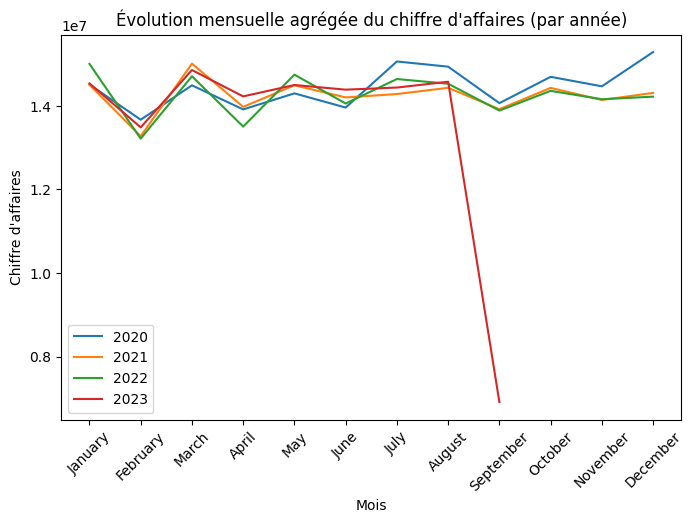

In [19]:
# 2) Evolution mensuelle des ventes
aggregated_evolution = Base_Magasins_Nord.groupby(['Purchase_Year', 'Purchase_Month'])['Total Purchase Amount'].sum().reset_index()
# Définition l'ordre des mois dans l'année
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August','September','October','November','December']
# Création du graphique
plt.figure(figsize=(8, 5))

# Boucle pour créer une courbe pour chaque année
for year in aggregated_evolution['Purchase_Year'].unique():
    year_data = aggregated_evolution[aggregated_evolution['Purchase_Year'] == year]
     # Tri des données par mois
    year_data = year_data.sort_values(by='Purchase_Month', key=lambda x: x.map({k: i for i, k in enumerate(month_order)}))

    plt.plot(year_data['Purchase_Month'], year_data['Total Purchase Amount'], label=str(year))

# Ajout de labels et titres
plt.xlabel('Mois')
plt.ylabel('Chiffre d\'affaires')
plt.title('Évolution mensuelle agrégée du chiffre d\'affaires (par année)')
plt.legend()  # Ajoute la légende avec les années

# Affichage du graphique
plt.xticks(month_order, calendar.month_name[1:], rotation=45) # Ajustement automatique de l'espacement
plt.show()

D'après le graphique ci-dessus, on peut voir que durant ces années , il y a des périodes spécifiques où les ventes sont à la baisse et des périodes précises où elles sont à la hausse. En général les périodes de baisse des ventes sont suivi de hausse des ventes et vice versa.
Toutefois le mois de février est le mois où les ventes sont les plus faibles au cours de ces 4 dernières années.

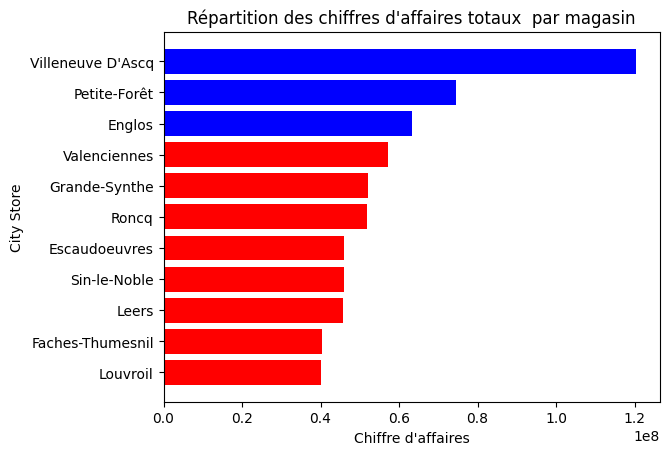

In [20]:
# 3- Répartition du chiffre d'affaires par magasin .
#(Si les chiffres d'affaires sont inférieurs à la moyenne alors les barres sont en rouge, sinon en bleu)
#  Agrégation des données en calculant la somme des ventes par magasin
agg_data = Base_Magasins_Nord.groupby('CITY_STORE')['Total Purchase Amount'].sum().reset_index()
agg_data = agg_data.sort_values('Total Purchase Amount')
# Calcul de la moyenne des ventes sur l'ensemble des magasins
mean_value = agg_data['Total Purchase Amount'].mean()
# Création une liste de couleurs en fonction de la comparaison à la moyenne
colors = ['blue' if x > mean_value else 'red' for x in agg_data['Total Purchase Amount']]
# Création d'un graphique en barres horizontales
plt.barh(agg_data['CITY_STORE'], agg_data['Total Purchase Amount'],color=colors)

# Ajoutez des étiquettes pour les axes x et y, ainsi qu'un titre
plt.xlabel('Chiffre d\'affaires')
plt.ylabel('City Store')
plt.title('Répartition des chiffres d\'affaires totaux  par magasin')

# Affichez le graphique
plt.show()

Pour les 11 magasins du Nord, seulement 3 magasins (magasins Villeneuve d'Ascq, magasin Petite-Forêt et magasin Englos) ont leur vente totale supérieure à la moyenne des ventes pour la période. La moyenne des ventes pour la période est de 2725.5 euros.  Le magasin de Villeneuve d'Ascq a les ventes les plus élévés au cours de la période et celles-ci sont deux fois plus que la moyenne. Les magasins de Louvroil et de Faches-Thumesnil ont les ventes les plus faibles au cours de la période.

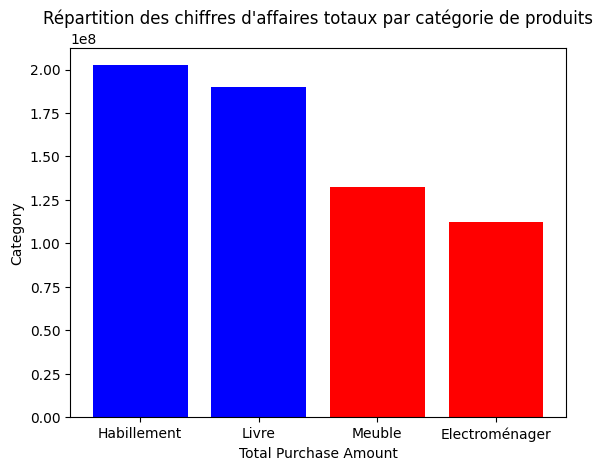

,Category,Total Purchase Amount,Percentage
1,Habillement,202498134,31.771934
2,Livre,190059676,29.820342
3,Meuble,132575065,20.801013
0,Electroménager,112216216,17.606712


In [21]:
# 4) Répartition des chiffres d'affaires par catégorie de produits
# Si le CA dépasse  le seuil 150000000 la barre est en blue, sinon en rouge
#  Agrégation des données en calculant la somme des ventes par magasin
agg_data = Base_Magasins_Nord.groupby('Category')['Total Purchase Amount'].sum().reset_index()
agg_data = agg_data.sort_values('Total Purchase Amount',ascending=False)

# a) Création  graphique des ventes par magasin
# Création une liste de couleurs en fonction de la valeur seuil 150000000
colors2 = ['blue' if x > 150000000 else 'red' for x in agg_data['Total Purchase Amount']]
plt.bar(agg_data['Category'], agg_data['Total Purchase Amount'],color=colors2)
# Ajoutez des étiquettes pour les axes x et y, ainsi qu'un titre
plt.xlabel('Total Purchase Amount')
plt.ylabel('Category')
plt.title('Répartition des chiffres d\'affaires totaux par catégorie de produits')

# Affichez le graphique
plt.show()
# b)Création tableau des ventes par magasin
# Calculez le total de 'Total Purchase Amount'
total_amount = agg_data['Total Purchase Amount'].sum()
agg_data['Percentage'] = agg_data['Total Purchase Amount'].apply(lambda x: (x / total_amount) * 100)
# Affichez le tableau avec les pourcentages
agg_data

D'après le graphique ci-dessus on peut voir que Les deux catégories de produits les plus vendues sont respectivement Habillement et Livre dans les magasins de l'enseigne qui sont dans le Nord. Les produits électroménager et les meubles sont les moins vendus.
De plus, l'enseigne avait fixé un seuil de vente minimun de 150 000 000 par catégorie de produits. Et seuls les produits de catégorie Habillement et Livre ont atteint ce seuil; elles l'ont même largement dépassé.                        
On peut remarquer aussi que 31% des chiffres des ventes totales proviennent des produits d'habillment et 17% des chiffres de ventes totales proviennent des produits électroménager.



---



En somme pour l'analyse des chiffres d'affaire nous pouvons conclure que:
* Les ventes ont été les plus élevé en 2020 et les moins élevé en 2021 au cours de la période 2020-2022.
* Les ventes connaissent une baisse considérable tous les mois de février de la période
* Le magasin de Villeneuve d'Ascq  a les ventes les plus élevé et le  magasin de Louvroil a les ventes les plus faibles au cours de la période 2020-2023
* Les produits de catégorie Habillement sont les plus vendus  et les produits de catégories électroménager sont les moins vendus au cours de la période 2020-2023.

**1.3.2- Analyse des Chiffres d'affaires en fonction des caractéristiques des clients**

Nous regarderons :
* La répartition annuelle des achats des clients par le genre des client
* La répartition annuelle des achats des clients par l'age des client
* La répartition annuelle des achats des clients par la méthode de paiement des client

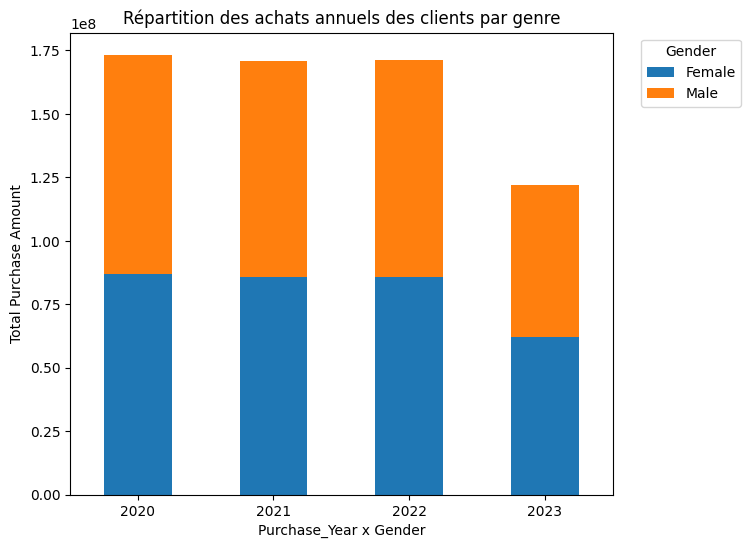

Purchase_Year  Gender
2020           Female    50.11
               Male      49.89
2021           Female    50.21
               Male      49.79
2022           Female    50.02
               Male      49.98
2023           Female    51.00
               Male      49.00
Name: Total Purchase Amount, dtype: float64

In [22]:
# 1) Répartition des chiffres d'affaires par année et par genre
# Répartition graphique
graph_empile(Base_Magasins_Nord, 'Purchase_Year', 'Gender', 'Total Purchase Amount', 'Répartition des achats annuels des clients par genre')
# Résumé en pourcentage
resume_pourcentage(Base_Magasins_Nord, 'Purchase_Year', 'Gender', 'Total Purchase Amount')

En 2020, 50.1% des montants des achats sont effectué par les femmes contre 49,9% par les hommes. Et Il n'y a pas eu de changement considérable dans cette répartion tout au long de la période.

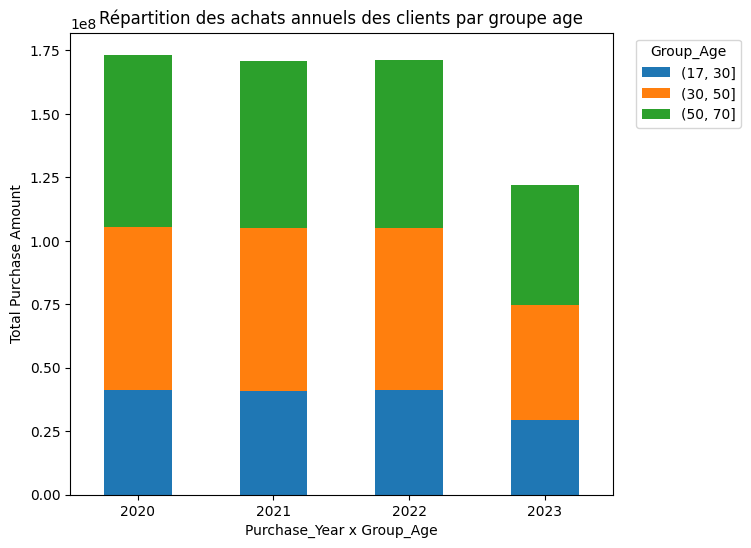

Purchase_Year  Group_Age
2020           (17, 30]     23.73
               (30, 50]     37.15
               (50, 70]     39.11
2021           (17, 30]     23.88
               (30, 50]     37.55
               (50, 70]     38.57
2022           (17, 30]     24.11
               (30, 50]     37.36
               (50, 70]     38.53
2023           (17, 30]     24.06
               (30, 50]     37.12
               (50, 70]     38.82
Name: Total Purchase Amount, dtype: float64

In [23]:
# 2) Répartition des chiffres d'affaires par année et par  groupe d'age
# Répartition graphique
graph_empile(Base_Magasins_Nord, 'Purchase_Year', 'Group_Age', 'Total Purchase Amount', 'Répartition des achats annuels des clients par groupe age')
# Résumé en pourcentage
resume_pourcentage(Base_Magasins_Nord, 'Purchase_Year', 'Group_Age', 'Total Purchase Amount')

En 2020, 23.7% des montants des achats ont été effectué par des clients agés entre 18 à 30 ans, 37.2% par des clients agés entre 31 et 50 ans, 39.1% par des clients agés de 51 à 70 ans. Les répartitions ont pratiquement été les mêmes tout au long de la période 2020-2023.

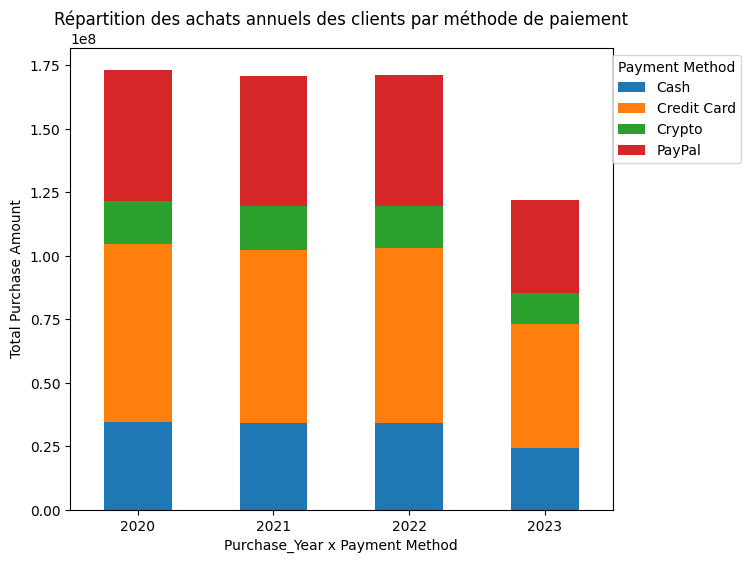

Purchase_Year  Payment Method
2020           Cash              19.90
               Credit Card       40.48
               Crypto             9.81
               PayPal            29.81
2021           Cash              19.93
               Credit Card       40.00
               Crypto            10.04
               PayPal            30.03
2022           Cash              19.96
               Credit Card       40.19
               Crypto             9.87
               PayPal            29.99
2023           Cash              19.86
               Credit Card       40.19
               Crypto             9.99
               PayPal            29.96
Name: Total Purchase Amount, dtype: float64

In [24]:
# 3) Répartition des achats par année et par méthode de paiement
# # Répartition graphique
graph_empile(Base_Magasins_Nord, 'Purchase_Year', 'Payment Method', 'Total Purchase Amount', 'Répartition des achats annuels des clients par méthode de paiement')
# résumé en pourcentage
resume_pourcentage(Base_Magasins_Nord, 'Purchase_Year', 'Payment Method', 'Total Purchase Amount')

40.5% des ventes totales proviennent des clients qui paient par carte de crédit, 29.8% de ceux qui paient par paypal, 19.9% de ceux qui paient par cash et 9.8% de ceux qui paient par crypto. Il n'y a pas eu de changements significatives dans ces proportions au cours de la période 2020-2023.

 En somme, pour l'analyse des chiffres d'affaires en fonction des caractéristiques des clients nous pouvons conclure que:
 * Les femmes rapportent quasiment autant d'argent aux magasins du Nord que les hommes
 * 39% des chiffres d'affaires proviennent des clients  agés entre 51 à 70 ans.
 * 40.5% des chiffres d'affaires proviennent des clients qui paient carte de crédits.

**1.3.3- Analyse des produits achetés par les clients**

Nous regarderons :
* La répartition des produits achetés dans chaque catégorie de produits
* La répartition des produits retournés
* La répartition des produits retounés par catégorie

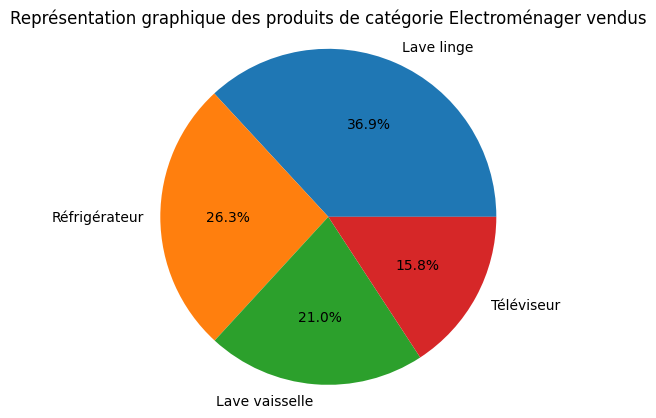

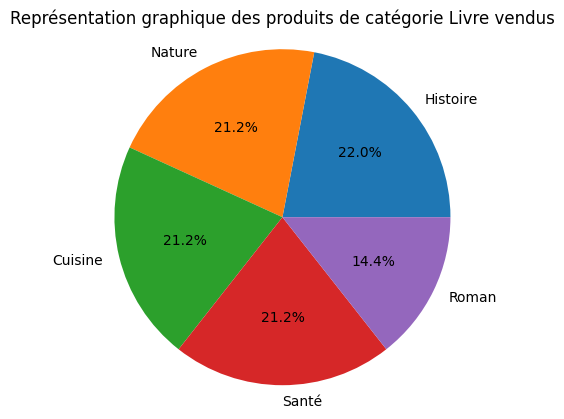

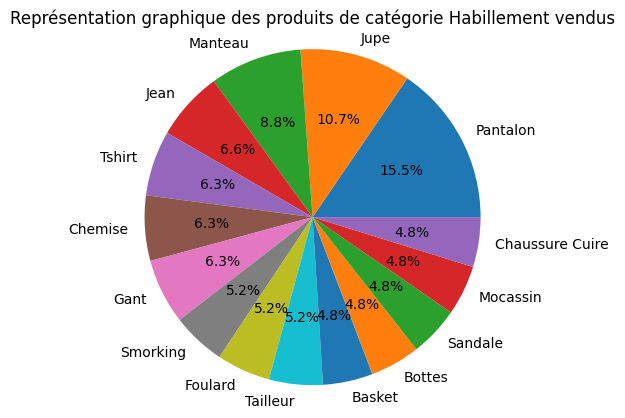

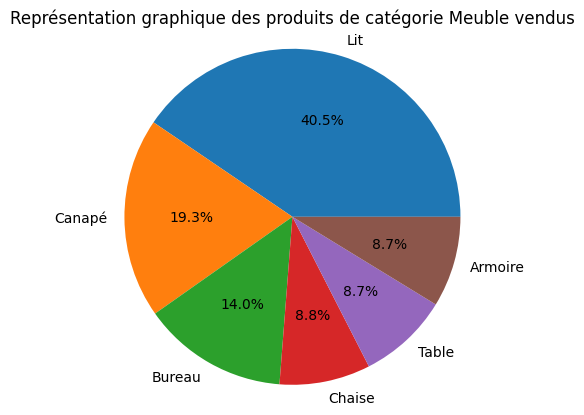

In [48]:
# 1) Répartion des produits achetés dans chaque catégorie
# Obtenir les modalités d'une colonne dans une liste
liste_modalites = Base_Magasins_Nord['Category'].unique().tolist()

# Crée une boucle pour parcourir la liste des catégorie,
# Pour chaque catégorie, filtrer la base et créer le graphique ayant cette modalité comme catégorie
for i,modalite in enumerate(liste_modalites):
    # Filtrer la base de données pour la modalité actuelle
    base_filtree = Base_Magasins_Nord[Base_Magasins_Nord['Category'] == modalite]
    # Appeler la fonction de graphique circulaire pour la base filtrée
    graphique_circulaire(base_filtree, 'Product_Name', f"Représentation graphique des produits de catégorie {modalite} vendus")


* Le lave-linge est le produit électroménager le plus acheté (il représente 40% des achats de produits électroménager), alors que les téléviseurs sont les moins acheté (16% des produits electroménagers achetés).
* Les livres d'histoire sont les plus achetés (22% des achats de livres) et les romans les moins achetés (14% des achats de livres).
* Les pantalons sont les habits les plus achetés (15.5% des achats d'habits). Les chausures sont également achetés en grande proportion (4.8% pour les baskets, 4.8% pour les mocassins, 4.8% pour les sandales, 4.8% pour les chaussures en cuir et 4.8% pour les bottes).  les smoking, les tailleurs et les foulards sont les moins achetés (5.2% chacun).
* Les lits sont les meubles les plus achetés (40.5% des achats des meubles) et les chaises sont les moins achetés (8.8% des achats de meuble).

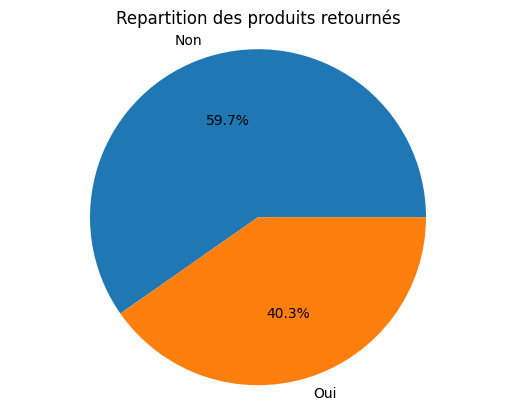

In [26]:
# 2) Répartition des produits retournés
# Changement des noms des modalités de la variable Returns. Les 1 seront des oui et les 0 des non
Base_Magasins_Nord1=Base_Magasins_Nord
Base_Magasins_Nord1['Returns'] = Base_Magasins_Nord1['Returns'].replace({1: 'Oui', 0: 'Non'})
# Création du graphique
graphique_circulaire(Base_Magasins_Nord1, 'Returns', 'Repartition des produits retournés')

40 % des produits achetés par les clients ont été retourné contre 60% de produits achetés qui n'ont pas été retourné.

<ipython-input-27-3f83408f49b5>:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  oui_proportions = contingency_table['Non'] / contingency_table.sum(axis=1)
<ipython-input-27-3f83408f49b5>:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  non_proportions = contingency_table['Oui'] / contingency_table.sum(axis=1)


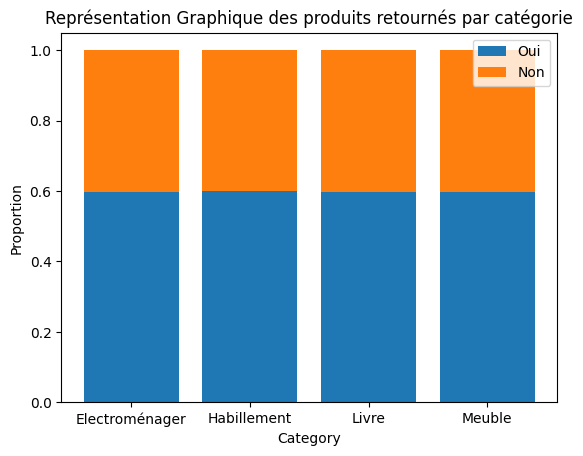

Returns,Category,Non,Oui
0,Electroménager,59.59,40.41
1,Habillement,59.87,40.13
2,Livre,59.70,40.30
3,Meuble,59.63,40.37


In [27]:
 #3) Répartion des catégorie de produits achetés suivant qu'ils ont été retourné ou non
# Table de contingence entre 'Category' et 'Returns'
contingency_table = pd.crosstab(Base_Magasins_Nord1['Category'], Base_Magasins_Nord1['Returns']).reset_index()
# Calcul des proportions de "oui" et de "non" pour chaque catégorie de produits
oui_proportions = contingency_table['Non'] / contingency_table.sum(axis=1)
non_proportions = contingency_table['Oui'] / contingency_table.sum(axis=1)
oui_proportions
# Les catégories de home_ownership
Category=contingency_table['Category']
x = range(len(Category))

# Tracé du graphique
plt.bar(x, oui_proportions, label='Oui')
plt.bar(x, non_proportions, label='Non', bottom=oui_proportions)

plt.xlabel('Category')
plt.ylabel('Proportion')
plt.title('Représentation Graphique des produits retournés par catégorie')
plt.xticks(x,Category)
plt.legend()
plt.show()

# Tableau croisé
contingency_table = pd.crosstab(Base_Magasins_Nord1['Category'], Base_Magasins_Nord1['Returns'],normalize='index').reset_index()
contingency_table['Non']=round(contingency_table['Non']*100,2)
contingency_table['Oui']=round(contingency_table['Oui']*100,2)
contingency_table

La catégorie de produits ne semble pas expliquer le fait qu'un produit ait été retourné ou non. La répartition de produit retourné est pratiquement la même dans toutes les catégories (40% retournés contre 60% non retournés).

En somme pour cette l'analyse des produits achetés par les clients nous pouvons retenir que:
* Les laves linges sont les életroménagés les plus achetés les livres d'histoire sont les livres les plus achetés, les pantalons et les chaussures sont les produits d'habillements les plus achetés et les lits sont les meubles les plus achetés.
* 40% des produits achetés par les clients ont été retourné.
* Pour toutes les 4 catégories de produits environ 40% des produits achetés par les clients ont été retourné.


**1.3.4- Analyse de la fréquence d'achats des clients**

In [28]:
# 1) Nombre de clients unique de la base
nombre_clients_uniques = Base_Magasins_Nord1['Customer ID'].nunique()
nombre_achats_total=len(Base_Magasins_Nord1)
print('Les ',nombre_achats_total,'achats totaux  ont été effectué par ',nombre_clients_uniques,'clients différents')

Les  233845 achats totaux  ont été effectué par  49482 clients différents


In [29]:
# 2- création  de la table contenant le nombre d'achats annuel effectué par chaque client unique (les 49482 clients uniques)
achat_annuel_client= Base_Magasins_Nord.pivot_table(index='Customer ID', columns='Purchase_Year', aggfunc='size', fill_value=0).reset_index()
# Affichage des 3 premières lignes de la table
achat_annuel_client.head()

Purchase_Year,Customer ID,2020,2021,2022,2023
0,1,0,0,0,1
1,2,0,2,1,0
2,3,1,3,0,2
3,4,1,0,2,1
4,5,3,2,1,2


In [30]:
# 2.1- Le nombre d'achats maximum et minimum effectué  pour chaque année
max_min_achat_annuel = achat_annuel_client[['2020', '2021', '2022', '2023']].agg(['min', 'max'])
# 2.2- Le nombre d'achats total effectué par tous les clients pour chaque année
total_achats_annuel = achat_annuel_client[['2020', '2021', '2022', '2023']].sum()
print(total_achats_annuel)
print('   \n      ')
print(max_min_achat_annuel)

Purchase_Year
2020    63662
2021    62752
2022    62804
2023    44627
dtype: int64
   
      
Purchase_Year  2020  2021  2022  2023
min               0     0     0     0
max               9     8     8     7


* En 2020 le client qui a acheté le plus de fois a acheté 9 fois dans les magasins du Nord.
* En 2021 le client qui a acheté le plus de fois a acheté 8 fois dans les magasins du Nord.
* En 2022 le client qui a acheté le plus de fois a acheté 8 fois dans les magasins du Nord.
* En 2023 le client qui a acheté le plus de fois a acheté 7 fois dans les magasins du Nord.

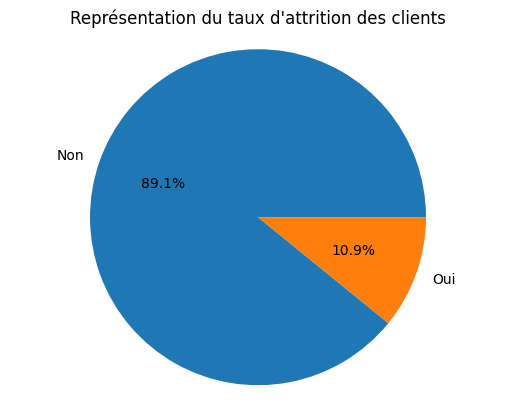

In [31]:
# 3- Création de la variable attrition (une variable binaire) et représentation graphique de la variable attrition
# Il existe déjà dans la base une variable appelé churn (attrition).
# Mais les responsables ne sont pas en mesure de me donner des explications sur la façon dont elle a été crée.
# Alors j'ai décidé de créer un variable d'attrition que je vais utiliser dans la suite de mes analyses.
# Le manager m'a expliqué qu'un client a fait attrition s'il n'a rien acheté au cours des 2 dernières années (en 2022 et 2023)
# Création de la variable attrition
achat_annuel_client['attrition'] = achat_annuel_client.apply(lambda row: 'Oui' if (row['2022'] == 0) and (row['2023'] == 0) else 'Non', axis=1)
# Représentation graphique de la variable Attrition
graphique_circulaire(achat_annuel_client, 'attrition', 'Représentation du taux d\'attrition des clients')

Le taux d'attrition des clients pour la période 2020-2023 est de 11% .

### **1.4- Développement d'un modèle pour expliquer et prédire churn**
Dans cette partie du travail, nous allons essayer de modéliser l'attrition des clients. Pour cela nous allons suivre ces étapes:
* Choix des variables du modèle
* Préparation des données pour la modélisation
* Entrainement des modèles sur le jeu de données d'entrainement
* Evaluation des modèles sur le jeu de données test

**1.4.1- Choix des variables du modèle**

In [32]:
# Création de la base de données pour la modélisation
#Jointure entre la table achat_annuel_client et la table Base_Magasin_Nord
# Pour avoir informations sur caractéristiques clients et attrition dans une seule table
Base_Model=pd.merge(achat_annuel_client, Base_Magasins_Nord, on='Customer ID')
# Pour faire la modélisation, nous allons conserver dans la base, chaque client une fois.
Base_Model1=Base_Model.drop_duplicates(subset='Customer ID')
# La variable à expliquer du modèle: attrition
# Les variables explicatives choisies :Total Purchase Amount,Payment Method,Returns, Age, Gender,CITY_STORE,Category
Base_Model2=Base_Model1[['attrition','Total Purchase Amount','Payment Method','Age','Gender','CITY_STORE','Category']]
Base_Model2.head()

,attrition,Total Purchase Amount,Payment Method,Age,Gender,CITY_STORE,Category
0,Non,3491,PayPal,70,Male,Valenciennes,Livre
1,Non,2819,PayPal,27,Female,Louvroil,Electroménager
4,Non,4415,PayPal,23,Female,Petite-Forêt,Livre
10,Non,4266,PayPal,66,Male,Petite-Forêt,Habillement
14,Non,2353,Credit Card,26,Female,Grande-Synthe,Electroménager


**1.4.2- Préparation des données pour la modélisation**

In [33]:
# 1- Mise en forme des données
# 5 variables sur 7 de la base de modélisation ne sont pas au format numérique.
# Sklearn nécessite des variables au format numérique. Alors, nous allons les transformer en format numérique
# a) Renommer les modalités de la variable attrition
Base_Model2['attrition'] = Base_Model2['attrition'].replace({'Oui': 1, 'Non': 0})
# b) Renommer les modalités de la variable Gender
Base_Model2['Gender'] = Base_Model2['Gender'].replace({'Male': 1, 'Female': 0})
# c)La variable Payment Method  a 4 modalités, nous allons transformer n-1 de ces modalités en une variable binaire
dummies1= pd.get_dummies(Base_Model2['Payment Method'],drop_first=True)
# d)La variable CITY_STORE  a 11 modalités, nous allons transformer n-1 de ces modalités en une variable binaire
dummies2= pd.get_dummies(Base_Model2['CITY_STORE'],drop_first=True)
# e)La variable Category  a 4 modalités, nous allons transformer n-1 de ces modalités en une variable binaire
dummies3= pd.get_dummies(Base_Model2['Category'],drop_first=True)
# f)Ajout des variables dummies dans la Base_Model
Base_Model2=pd.concat([Base_Model2,dummies1,dummies2,dummies3],axis=1)
# g) Suppression des variables catégorielles d'origine
Base_Model2=Base_Model2.drop(['Payment Method','CITY_STORE','Category'],axis=1)
Base_Model2.head(3)

<ipython-input-33-4e611c70896e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Base_Model2['attrition'] = Base_Model2['attrition'].replace({'Oui': 1, 'Non': 0})
<ipython-input-33-4e611c70896e>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Base_Model2['Gender'] = Base_Model2['Gender'].replace({'Male': 1, 'Female': 0})


,attrition,Total Purchase Amount,Age,Gender,Credit Card,Crypto,PayPal,Escaudoeuvres,Faches-Thumesnil,Grande-Synthe,Leers,Louvroil,Petite-Forêt,Roncq,Sin-le-Noble,Valenciennes,Villeneuve D'Ascq,Habillement,Livre,Meuble
0,0,3491,70,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0
1,0,2819,27,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
4,0,4415,23,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0


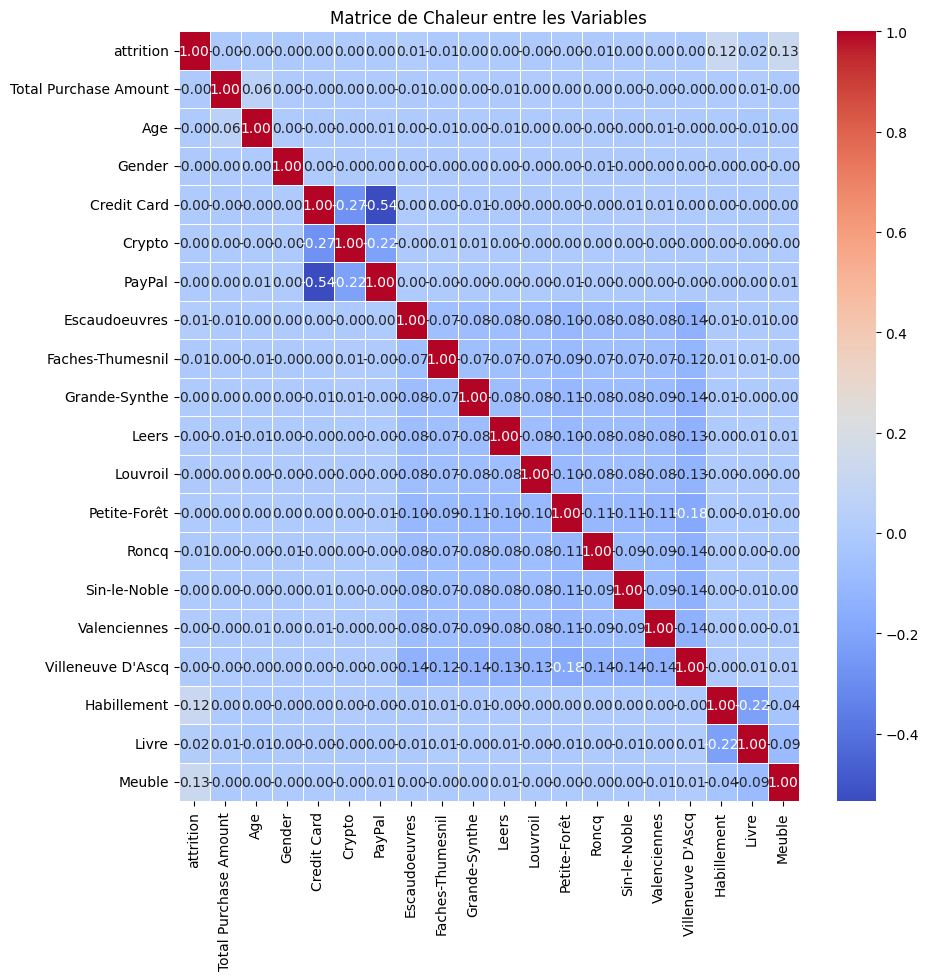

In [34]:
# 2- Etudions la corrélation entre les variables de la base du modèle
# Création d'une carte de chaleur entre les variables  du modèle
plt.figure(figsize=(10, 10))
matrice_correlation = Base_Model2.corr()
sns.heatmap(matrice_correlation, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matrice de Chaleur entre les Variables')
plt.show()

Le graphique de corrélation montre qu'il y a de très faibles corrélations entre la variable attrition et les variables explicatives. Il est donc fort probable que le modèle ne soit pas performant.

In [35]:
# 3- Split data: Séparer de la base de données en données d'entrainement et données test
# 75% des données seront consacrées à l'entrainement du modèle et 25% pour tester le modèle
# Créons la matrice des variables explicatives X et la matrice de la variable cible y
X = Base_Model2.drop('attrition', axis=1)
y = Base_Model2['attrition']
# Utiliser train_test_split pour diviser les données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

**1.4.3- Entrainement des modèles**

4 algorithmes vont être utilisé pour l'entrainement:
* K plus proches voisin
* Régression logistique
* Arbre de décision
* Random Forest

Nous allons fournir aux hyperparamètre de chacun de ces algorithmes un ensemble de valeurs, ensuite nous utiliserons la validation gridsearch pour selectionner les hyperparamètres qui fournissent le meilleur métrique "recall".


In [36]:
# Entrainement des modèles

from sklearn.metrics import precision_score
# Modèles
knn_model = KNeighborsClassifier()
logistic_model = LogisticRegression()
decision_tree_model = DecisionTreeClassifier()
random_forest_model = RandomForestClassifier()

# Grilles des hyperparamètres à explorer
param_grid_knn = {'n_neighbors': [3,4, 5, 7]}
param_grid_logistic = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
param_grid_decision_tree = {'max_depth': [1,2,3,5,10,15,20, 30]}
param_grid_random_forest = {'n_estimators': [50, 100, 150], 'max_depth': [ 2,3,5,10,15, 20, 30]}


# Utiliser GridSearchCV pour trouver les meilleurs hyperparamètres
grid_search_knn = GridSearchCV(knn_model, param_grid_knn, cv=5 ,scoring="recall")
grid_search_logistic = GridSearchCV(logistic_model, param_grid_logistic, cv=5 ,scoring="recall")
grid_search_decision_tree = GridSearchCV(decision_tree_model, param_grid_decision_tree, cv=5,scoring="recall")
grid_search_random_forest = GridSearchCV(random_forest_model, param_grid_random_forest, cv=5,scoring="recall")

# Entraîner les modèles
grid_search_knn.fit(X_train, y_train)
grid_search_logistic.fit(X_train, y_train)
grid_search_decision_tree.fit(X_train, y_train)
grid_search_random_forest.fit(X_train, y_train)

# Afficher les meilleurs hyperparamètres pour chaque modèle
print("Meilleurs hyperparamètres pour KNN:", grid_search_knn.best_params_)
print("Meilleurs hyperparamètres pour Régression Logistique:", grid_search_logistic.best_params_)
print("Meilleurs hyperparamètres pour Arbre de Décision:", grid_search_decision_tree.best_params_,grid_search_decision_tree.best_score_)
print("Meilleurs hyperparamètres pour Random forest:", grid_search_random_forest.best_params_, grid_search_random_forest.best_score_)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Meilleurs hyperparamètres pour KNN: {'n_neighbors': 3}
Meilleurs hyperparamètres pour Régression Logistique: {'C': 0.001}
Meilleurs hyperparamètres pour Arbre de Décision: {'max_depth': 30} 0.13092790262172285
Meilleurs hyperparamètres pour Random forest: {'max_depth': 30, 'n_estimators': 150} 0.0442247191011236


**1.4.5- Evaluation des modèles sur le jeu de données test**

Chacun des algorithmes va être utilisé pour prédire l'attrition en utilisant le jeu de données test. Pour évaluer la qualité des prédictions, la matrice de confusion et les métriques accuracy, recall et f1-score seront affichées pour chacun des 4 modèles.

In [37]:
#1- Métriques
from sklearn.metrics import confusion_matrix, classification_report
# Utilisation des modèles entraînés avec les meilleurs hyperparamètres
decision_tree_model = grid_search_decision_tree.best_estimator_
random_forest_model = grid_search_random_forest.best_estimator_
# Prédire sur l'ensemble de test
y_pred_knn = grid_search_knn.predict(X_test)
y_pred_logistic = grid_search_logistic.predict(X_test)
y_pred_decision_tree = decision_tree_model.predict(X_test)
y_pred_random_forest = random_forest_model.predict(X_test)

# Calculer les matrices de confusion
cm_knn = confusion_matrix(y_test, y_pred_knn)
cm_logistic = confusion_matrix(y_test, y_pred_logistic)
cm_decision_tree = confusion_matrix(y_test, y_pred_decision_tree)
cm_random_forest = confusion_matrix(y_test, y_pred_random_forest)

# Calculer le rappel et le F1-score
report_knn = classification_report(y_test, y_pred_knn)
report_logistic = classification_report(y_test, y_pred_logistic)
report_decision_tree = classification_report(y_test, y_pred_decision_tree)
report_random_forest = classification_report(y_test, y_pred_random_forest)

# Afficher les matrices de confusion, le rappel et le F1-score

print("\nMatrice de Confusion - knn:\n", cm_knn)
print("Rappel et F1-score - knn:\n", report_knn)

print("\nMatrice de Confusion - logistic:\n", cm_logistic)
print("Rappel et F1-score - logistic:\n", report_logistic)

print("\nMatrice de Confusion - Arbre de Décision:\n", cm_decision_tree)
print("Rappel et F1-score - Arbre de Décision:\n", report_decision_tree)


print("\nMatrice de Confusion - Forêt Aléatoire:\n", cm_random_forest)
print("Rappel et F1-score - Forêt Aléatoire:\n", report_random_forest)



Matrice de Confusion - knn:
 [[10604   392]
 [ 1336    39]]
Rappel et F1-score - knn:
               precision    recall  f1-score   support

           0       0.89      0.96      0.92     10996
           1       0.09      0.03      0.04      1375

    accuracy                           0.86     12371
   macro avg       0.49      0.50      0.48     12371
weighted avg       0.80      0.86      0.83     12371


Matrice de Confusion - logistic:
 [[10996     0]
 [ 1375     0]]
Rappel et F1-score - logistic:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94     10996
           1       0.00      0.00      0.00      1375

    accuracy                           0.89     12371
   macro avg       0.44      0.50      0.47     12371
weighted avg       0.79      0.89      0.84     12371


Matrice de Confusion - Arbre de Décision:
 [[10013   983]
 [ 1216   159]]
Rappel et F1-score - Arbre de Décision:
               precision    recall  f1-score 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Les résultats montrent que les modèles ont des accuracy très élévé, toutefois ce ne sont pas de bon modèles. En effet, les modèles prédisent très mal la modalité attrition=oui. Or c'est surtout ce qui nous intéresse pour cette modélisation.

Cela pourait s'expliquer principalement par deux éléments.
* D'une part il y a une déséquilibre des classes : 90% de personnes qui n'ont pas fait attrition contre 10% qui l'on fait. Ce qui rend le modèle plus sensible à prédire les non attrition. Pour palier à cela, on pourrait utiliser des techniques de rééquilibrage de classes.
* D'autre part, le manque de corrélation entre la variable cible et les variables explicatives. On pourrait remédier cela en intégrant des variables explicatives plus corrélées  par exemple le prix des produits, la distance parcourru par le client pour se rendre aux magasins.

Dans tout cela, le modèle d'arbre de décision est le moins pire, il permet de prédire 12% des attritions du jeu de données test.

## **Partie 2: SQL**


Après la modélisation, nous avons voulu faire une analyse  des ventes suivant les fournisseurs des magasins du Nord. Nous avons utilisé à cet effet des requêtes SQL pour interroger la table product et la table  sales.

**2.0- Création de la base de données SQL**

In [38]:
#1- Exporter la DataFrame Sales crée sur python vers un fichier Excel
Sales.to_excel('Sales_Pandas.xlsx', index=False)
# Télécharger le fichier excel sur mon disque local
files.download('Sales_Pandas.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [39]:
# 2-Importer le fichier depuis mon disque local vers colab
data_to_load = files.upload()

Saving Sales_Pandas.xlsx to Sales_Pandas (1).xlsx


In [40]:
Sales.head()

,Customer ID,Purchase Date,Product_Key,Product Price,Quantity,Total Purchase Amount,Payment Method,Returns,Customer Name,Age,Gender,Churn,ID_Store
0,46251,2020-09-08 09:38:00,EM01,12,3,740,Credit Card,0.0,Christine Hernandez,37.0,Male,0,1
1,13593,2023-04-15 03:02:00,EM02,73,1,1896,Credit Card,0.0,James Grant,49.0,Female,1,9
2,28805,2023-09-13 04:24:00,EM03,394,2,1993,Credit Card,0.0,Jose Collier,19.0,Male,0,6
3,12163,2020-11-28 16:48:00,EM04,28,4,495,Credit Card,0.0,Sonia Moreno,67.0,Male,0,7
4,12163,2020-08-21 09:23:00,NaN,382,2,1532,PayPal,1.0,Sonia Moreno,67.0,Male,0,8


In [41]:
# 3- Création de la base de données SQL
# Cette base de données aura 2 tables: la table clients et la table produits
# Création et connection à la base de données SQL
conn = sqlite3.connect('Base_SQL.db')

# Création d'un curseur pour exécuter des commandes SQL dans Python
cursor = conn.cursor()

# Création de la table Clients dans la base Base_SQL
df_client = pd.read_excel('Sales_Pandas.xlsx',header=0)
df_client.to_sql('Clients', conn, index=False, if_exists='replace')

# Création de la table Produits dans la base Base_SQL
df_produits = pd.read_csv('Product_Data.csv',header=0,delimiter=";",encoding="latin1")
df_produits.to_sql('Produits', conn, index=False, if_exists='replace')

# Validation des tables crées
conn.commit()



**2.1- Les founisseurs des magasins du nord**

In [42]:
# 2.1.1- Le nombre de fournisseurs
#  Exécution de la requete SQL
query1 = "SELECT COUNT(DISTINCT Provider_City) FROM Produits;"
cursor.execute(query1)

# Récupérer le résultat
nombre_fournisseurs = cursor.fetchone()[0]

# Afficher le résultat
print("les magasins du Nord ont :", nombre_fournisseurs,"fournisseurs")


les magasins du Nord ont : 4 fournisseurs


In [43]:
#2.1.2- La provenance des différentes catégories de produits
 # Exécution de la requête SQL
query2 = "SELECT DISTINCT Category, Provider_City FROM Produits;"
cursor.execute(query2)
# Récupération des résultats
category_produits = cursor.fetchall()
# Affichage des résultats
for row in category_produits:
  print(row)

('Electroménager', 'Paris')
('Electroménager', 'Lyon')
('Electroménager', 'Nantes')
('Habillement', 'Lille')
('Habillement', 'Nantes')
('Habillement', 'Paris')
('Habillement', 'Lyon')
('Livre', 'Lille')
('Livre', 'Paris')
('Livre', 'Lyon')
('Livre', 'Nantes')
('Meuble', 'Lyon')
('Meuble', 'Lille')
('Meuble', 'Paris')
('Meuble', 'Nantes')


Les produits vendus dans les magasins du Nord proviennent des fournisseurs de Paris, Lyon, Nantes et Lille. Ces fournissent approvisionnent les magasins du Nord en produits électroménagers, produits vestimentaires , livres et meubles. Sauf les fournisseurs de Lille qui ne leur vend pas de l'électroménager.

**2.2-Montant et Quantité de produits des fournisseurs qui sont vendus**

In [44]:
# La Quantité totale de produits de chacun des fournisseurs vendus par les magasins du nord
# Et le montant moyen des produits de chacun des fournisseurs vendus par les magasins du nord
# Execution de la requete SQL
query3 = """
          SELECT Produits.Provider_City AS Fournisseurs, SUM(Clients.Quantity) AS Quantite , ROUND(AVG(Clients."Total Purchase Amount"),2)
          FROM Produits JOIN Clients ON Produits.Id_Product = Clients.Product_Key
          GROUP BY Fournisseurs
          ORDER BY Quantite  ;
          """

cursor.execute(query3)
# Récupération des résultats
quantite_montant = cursor.fetchall()

# Affichage des résultats
for row in quantite_montant:
  print(row)

('Nantes', 116111, 2725.98)
('Lyon', 155194, 2727.48)
('Lille', 185511, 2728.88)
('Paris', 246714, 2721.88)


Ce sont les produits provenant de Paris qui sont les plus acheté par les clients dans les magasins du Nord et les produits provenant de Nantes qui sont les plus achetés. Toutefois la moyenne des montants des ventes des produits provenant de Lille est la plus élevé et la moyenne des montants des produits provenant de Paris est la moins élevée.

**2.3- Montant et Quantité de produits des fournisseurs qui sont retournés**

In [45]:
# 1-  Quantité de produits retounés
# La Quantité totale de produits de chacun des fournisseurs vendus par les magasins du nord qui sont retournés
# Execution de la requete SQL
query4 = """
          SELECT Produits.Provider_City AS Fournisseurs, SUM(Clients.Returns) AS Retour
          FROM Produits JOIN Clients ON Produits.Id_Product = Clients.Product_Key
          GROUP BY Fournisseurs
          ORDER BY Retour DESC ;
          """

cursor.execute(query4)
# Récupération des résultats
quantite_montant = cursor.fetchall()

# Affichage des résultats
for row in quantite_montant:
  print(row)

('Paris', 33212.0)
('Lille', 24873.0)
('Lyon', 20626.0)
('Nantes', 15765.0)


In [46]:
# 2-Montant de produit retourné (Maximum et Minimum)
# Le montant minimum et le montant maximum de produits de chacun des fournisseurs vendus par les magasins du nord qui ont été retournés
# Execution de la requete SQL
query5 = """
          SELECT Produits.Provider_City AS Fournisseurs, MIN(Clients."Total Purchase Amount"), MAX(Clients."Total Purchase Amount") AS MAX
          FROM Produits JOIN Clients ON Produits.Id_Product = Clients.Product_Key
          WHERE Clients.Returns == 1
          GROUP BY Fournisseurs
          ORDER BY MAX
          ;
          """

cursor.execute(query5)
# Récupération des résultats
quantite_montant = cursor.fetchall()

# Affichage des résultats
for row in quantite_montant:
  print(row)

('Nantes', 108, 5334)
('Lille', 103, 5338)
('Lyon', 120, 5342)
('Paris', 107, 5350)


In [47]:
# Fermeture de la base de données SQL
conn.close()

# **Conclusion**

Dans le cadre de ce travail, l'objectif était d'analyser les ventes et l'attrition dans les magasins du Nord de cet enseigne sur la période 2020-2023

* Les analyses des ventes ont révélé que le chiffre d'affaires a atteint son niveau le plus élévé en 2020 et son niveau le plus faible en 2021 (2023 exclu). Et tous les mois de février, l'ensemble des magasins connaissent leur baisse de chiffre d'affaires le plus important.
* Les produits habillement vendus  représentent 22% du chiffre d'affaires total.
* 39% du chiffre d'affaires total proviennent des clients agés de 51 à 70 ans.
* Le Magasin de Villeneuve d'ascq a le chiffre d'affaires total le plus élévé et le magasin de Louvroil a le chiffre d'affaires total le plus faibles sur la période.
* Les produits  les plus  vendus proviennent des fournisseurs de Paris.
* Le taux d'attritition des clients est de 11 % au cours de la période.
